In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'ensemble_voting'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 744.20it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score.cpu().detach().numpy())
                TrainLoss_list1.append(unet_loss.cpu().detach().numpy())
                valScore_list2.append(segnet_val_score.cpu().detach().numpy())
                TrainLoss_list2.append(segnet_loss.cpu().detach().numpy())                
                valScore_list3.append(enet_val_score.cpu().detach().numpy())
                TrainLoss_list3.append(enet_loss.cpu().detach().numpy())
                valScore_list4.append(voting_val_score.cpu().detach().numpy())
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:17<00:00, 15.09img/s]

***
Unet Loss: 0.542406439781189     Segnet Loss: 0.7919266223907471     Enet Loss: 1.2885218858718872
Voting Loss: 0.8742849826812744


Epoch 1/50:  99%|█████████▊| 200/203 [00:20<00:00,  9.68img/s]


---
Unet Validation Dice Score: 0.292089581489563     Segnet Validation Dice Score: 0.04844001308083534     Enet Validation Dice Score: 0.23857617378234863
Ensemble Voting Validation Dice Loss: 1.1299817562103271
Ensemble Voting Validation Pixel Accuracy: 0.7206163908305921 
Ensemble Voting Validation MIoU: 0.4878610534310814
Ensemble Voting Validation Dice Score: 0.49423789978027344 


Epoch 2/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.37824302911758423     Segnet Loss: 0.42564475536346436     Enet Loss: 1.22086501121521
Voting Loss: 0.6749175985654196


Epoch 2/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.61img/s]


---
Unet Validation Dice Score: 0.6983385682106018     Segnet Validation Dice Score: 0.6032734513282776     Enet Validation Dice Score: 0.2600294053554535
Ensemble Voting Validation Dice Loss: 0.8770807385444641
Ensemble Voting Validation Pixel Accuracy: 0.9050060071443257 
Ensemble Voting Validation MIoU: 0.7434513241734465
Ensemble Voting Validation Dice Score: 0.7629895210266113 


Epoch 3/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.14img/s]

***
Unet Loss: 0.48848459124565125     Segnet Loss: 0.31821760535240173     Enet Loss: 1.148141622543335
Voting Loss: 0.6516146063804626


Epoch 3/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.66img/s]


---
Unet Validation Dice Score: 0.8135307431221008     Segnet Validation Dice Score: 0.7786495089530945     Enet Validation Dice Score: 0.28871122002601624
Ensemble Voting Validation Dice Loss: 0.7605912685394287
Ensemble Voting Validation Pixel Accuracy: 0.9346640068188048 
Ensemble Voting Validation MIoU: 0.7999504143207377
Ensemble Voting Validation Dice Score: 0.8143144845962524 


Epoch 4/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.35519349575042725     Segnet Loss: 0.24076835811138153     Enet Loss: 1.0895929336547852
Voting Loss: 0.5618515958388647


Epoch 4/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.50img/s]


---
Unet Validation Dice Score: 0.8441233038902283     Segnet Validation Dice Score: 0.8049940466880798     Enet Validation Dice Score: 0.32999712228775024
Ensemble Voting Validation Dice Loss: 0.7044591903686523
Ensemble Voting Validation Pixel Accuracy: 0.941696702388295 
Ensemble Voting Validation MIoU: 0.8114612726860093
Ensemble Voting Validation Dice Score: 0.8274636268615723 


Epoch 5/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.09img/s]

***
Unet Loss: 0.3431228995323181     Segnet Loss: 0.21368113160133362     Enet Loss: 0.9984307885169983
Voting Loss: 0.5184116065502167


Epoch 5/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.52img/s]


---
Unet Validation Dice Score: 0.7826029658317566     Segnet Validation Dice Score: 0.7867178320884705     Enet Validation Dice Score: 0.36346155405044556
Ensemble Voting Validation Dice Loss: 0.6738590002059937
Ensemble Voting Validation Pixel Accuracy: 0.9470062255859375 
Ensemble Voting Validation MIoU: 0.8180415554032676
Ensemble Voting Validation Dice Score: 0.7902526259422302 


Epoch 6/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.340021550655365     Segnet Loss: 0.29403963685035706     Enet Loss: 0.9896223545074463
Voting Loss: 0.5412278473377228


Epoch 6/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.54img/s]


---
Unet Validation Dice Score: 0.851015567779541     Segnet Validation Dice Score: 0.7973423004150391     Enet Validation Dice Score: 0.39318761229515076
Ensemble Voting Validation Dice Loss: 0.6452479362487793
Ensemble Voting Validation Pixel Accuracy: 0.9577949925472862 
Ensemble Voting Validation MIoU: 0.8548504260482981
Ensemble Voting Validation Dice Score: 0.8404325842857361 


Epoch 7/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.00img/s]

***
Unet Loss: 0.27638453245162964     Segnet Loss: 0.17112112045288086     Enet Loss: 0.8916230797767639
Voting Loss: 0.4463762442270915


Epoch 7/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.59img/s]


---
Unet Validation Dice Score: 0.8564050793647766     Segnet Validation Dice Score: 0.8179485201835632     Enet Validation Dice Score: 0.4311284124851227
Ensemble Voting Validation Dice Loss: 0.6285169124603271
Ensemble Voting Validation Pixel Accuracy: 0.9544899923759594 
Ensemble Voting Validation MIoU: 0.8456455232339808
Ensemble Voting Validation Dice Score: 0.841321587562561 


Epoch 8/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.25043821334838867     Segnet Loss: 0.1261025369167328     Enet Loss: 0.8257815837860107
Voting Loss: 0.4007741113503774


Epoch 8/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.60img/s]


---
Unet Validation Dice Score: 0.8512130975723267     Segnet Validation Dice Score: 0.8720275163650513     Enet Validation Dice Score: 0.46191078424453735
Ensemble Voting Validation Dice Loss: 0.6092565059661865
Ensemble Voting Validation Pixel Accuracy: 0.9501832660875822 
Ensemble Voting Validation MIoU: 0.8325300564319011
Ensemble Voting Validation Dice Score: 0.8764317631721497 


Epoch 9/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.93img/s]

***
Unet Loss: 0.21186760067939758     Segnet Loss: 0.11929741501808167     Enet Loss: 0.771386981010437
Voting Loss: 0.3675173322359721


Epoch 9/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.59img/s]


---
Unet Validation Dice Score: 0.8696069121360779     Segnet Validation Dice Score: 0.8726388812065125     Enet Validation Dice Score: 0.4998405873775482
Ensemble Voting Validation Dice Loss: 0.589044988155365
Ensemble Voting Validation Pixel Accuracy: 0.9581344336794134 
Ensemble Voting Validation MIoU: 0.8525150108604951
Ensemble Voting Validation Dice Score: 0.8806979060173035 


Epoch 10/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.06img/s]

***
Unet Loss: 0.24922572076320648     Segnet Loss: 0.2036057859659195     Enet Loss: 0.7300693392753601
Voting Loss: 0.39430028200149536


Epoch 10/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.53img/s]


---
Unet Validation Dice Score: 0.8700249791145325     Segnet Validation Dice Score: 0.8648180961608887     Enet Validation Dice Score: 0.5498294234275818
Ensemble Voting Validation Dice Loss: 0.575365424156189
Ensemble Voting Validation Pixel Accuracy: 0.9523061116536459 
Ensemble Voting Validation MIoU: 0.8417668444240896
Ensemble Voting Validation Dice Score: 0.880244255065918 


Epoch 11/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.89img/s]

***
Unet Loss: 0.2341153770685196     Segnet Loss: 0.1663699448108673     Enet Loss: 0.658906102180481
Voting Loss: 0.3531304746866226


Epoch 11/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.52img/s]


---
Unet Validation Dice Score: 0.8613762259483337     Segnet Validation Dice Score: 0.8771787881851196     Enet Validation Dice Score: 0.6005163192749023
Ensemble Voting Validation Dice Loss: 0.5650304555892944
Ensemble Voting Validation Pixel Accuracy: 0.9539974279570997 
Ensemble Voting Validation MIoU: 0.8462856765881965
Ensemble Voting Validation Dice Score: 0.878797173500061 


Epoch 12/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.76img/s]

***
Unet Loss: 0.19660058617591858     Segnet Loss: 0.11234694719314575     Enet Loss: 0.6482080817222595
Voting Loss: 0.31905187169710797


Epoch 12/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.39img/s]


---
Unet Validation Dice Score: 0.8753711581230164     Segnet Validation Dice Score: 0.8845376968383789     Enet Validation Dice Score: 0.6469921469688416
Ensemble Voting Validation Dice Loss: 0.5451338291168213
Ensemble Voting Validation Pixel Accuracy: 0.9560809219092653 
Ensemble Voting Validation MIoU: 0.851415879326654
Ensemble Voting Validation Dice Score: 0.8887322545051575 


Epoch 13/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.08img/s]

***
Unet Loss: 0.1762065291404724     Segnet Loss: 0.09654633700847626     Enet Loss: 0.6164236068725586
Voting Loss: 0.29639215767383575


Epoch 13/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.55img/s]


---
Unet Validation Dice Score: 0.8983237147331238     Segnet Validation Dice Score: 0.8800918459892273     Enet Validation Dice Score: 0.6951029300689697
Ensemble Voting Validation Dice Loss: 0.5254415273666382
Ensemble Voting Validation Pixel Accuracy: 0.966921889991091 
Ensemble Voting Validation MIoU: 0.8835619913918172
Ensemble Voting Validation Dice Score: 0.8951454162597656 


Epoch 14/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.14301201701164246     Segnet Loss: 0.0783495157957077     Enet Loss: 0.556616485118866
Voting Loss: 0.2593260059754054


Epoch 14/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.51img/s]


---
Unet Validation Dice Score: 0.8609794974327087     Segnet Validation Dice Score: 0.8963446617126465     Enet Validation Dice Score: 0.7250399589538574
Ensemble Voting Validation Dice Loss: 0.5267705917358398
Ensemble Voting Validation Pixel Accuracy: 0.9611441628974781 
Ensemble Voting Validation MIoU: 0.8678398459572974
Ensemble Voting Validation Dice Score: 0.8957527279853821 


Epoch 15/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
Unet Loss: 0.14893028140068054     Segnet Loss: 0.07744194567203522     Enet Loss: 0.5215308666229248
Voting Loss: 0.2493010312318802


Epoch 15/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.58img/s]


---
Unet Validation Dice Score: 0.9002301096916199     Segnet Validation Dice Score: 0.8775755763053894     Enet Validation Dice Score: 0.7590028047561646
Ensemble Voting Validation Dice Loss: 0.5126014351844788
Ensemble Voting Validation Pixel Accuracy: 0.9643857186300713 
Ensemble Voting Validation MIoU: 0.8763130636697047
Ensemble Voting Validation Dice Score: 0.8916783332824707 


Epoch 16/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.23img/s]

***
Unet Loss: 0.1266556978225708     Segnet Loss: 0.08641234040260315     Enet Loss: 0.4667934477329254
Voting Loss: 0.22662049531936646


Epoch 16/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.69img/s]


---
Unet Validation Dice Score: 0.8953005075454712     Segnet Validation Dice Score: 0.8856419920921326     Enet Validation Dice Score: 0.7868170142173767
Ensemble Voting Validation Dice Loss: 0.512229323387146
Ensemble Voting Validation Pixel Accuracy: 0.954507125051398 
Ensemble Voting Validation MIoU: 0.8505613060658925
Ensemble Voting Validation Dice Score: 0.8975419998168945 


Epoch 17/50:  99%|█████████▊| 200/203 [00:14<00:00, 14.89img/s]

***
Unet Loss: 0.19041699171066284     Segnet Loss: 0.15531215071678162     Enet Loss: 0.5064774751663208
Voting Loss: 0.28406887253125507


Epoch 17/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.67img/s]


---
Unet Validation Dice Score: 0.8752042055130005     Segnet Validation Dice Score: 0.8915035128593445     Enet Validation Dice Score: 0.788374662399292
Ensemble Voting Validation Dice Loss: 0.5014064311981201
Ensemble Voting Validation Pixel Accuracy: 0.9630798875239858 
Ensemble Voting Validation MIoU: 0.8714119766415117
Ensemble Voting Validation Dice Score: 0.8949801325798035 


Epoch 18/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.81img/s]

***
Unet Loss: 0.10616032034158707     Segnet Loss: 0.05496423318982124     Enet Loss: 0.45331135392189026
Voting Loss: 0.20481196915109953


Epoch 18/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.56img/s]


---
Unet Validation Dice Score: 0.9087509512901306     Segnet Validation Dice Score: 0.9006879925727844     Enet Validation Dice Score: 0.8038482069969177
Ensemble Voting Validation Dice Loss: 0.49279460310935974
Ensemble Voting Validation Pixel Accuracy: 0.9643024645353618 
Ensemble Voting Validation MIoU: 0.8774370540656015
Ensemble Voting Validation Dice Score: 0.9088229537010193 


Epoch 19/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.92img/s]

***
Unet Loss: 0.10090000182390213     Segnet Loss: 0.05788818746805191     Enet Loss: 0.47209617495536804
Voting Loss: 0.2102947880824407


Epoch 19/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.56img/s]


---
Unet Validation Dice Score: 0.9071747064590454     Segnet Validation Dice Score: 0.9057804346084595     Enet Validation Dice Score: 0.8099889755249023
Ensemble Voting Validation Dice Loss: 0.490556925535202
Ensemble Voting Validation Pixel Accuracy: 0.9622880366810581 
Ensemble Voting Validation MIoU: 0.8709426612139985
Ensemble Voting Validation Dice Score: 0.9105812311172485 


Epoch 20/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.98img/s]

***
Unet Loss: 0.1190396398305893     Segnet Loss: 0.05204362794756889     Enet Loss: 0.4616027772426605
Voting Loss: 0.2108953483402729


Epoch 20/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.53img/s]


---
Unet Validation Dice Score: 0.9080420732498169     Segnet Validation Dice Score: 0.9037579894065857     Enet Validation Dice Score: 0.8099403381347656
Ensemble Voting Validation Dice Loss: 0.4898671507835388
Ensemble Voting Validation Pixel Accuracy: 0.9625329804002193 
Ensemble Voting Validation MIoU: 0.8720427424300858
Ensemble Voting Validation Dice Score: 0.9079553484916687 


Epoch 21/50:  99%|█████████▊| 200/203 [00:14<00:00, 14.95img/s]

***
Unet Loss: 0.11295606940984726     Segnet Loss: 0.04830923676490784     Enet Loss: 0.4528631865978241
Voting Loss: 0.20470949759085974


Epoch 21/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.71img/s]


---
Unet Validation Dice Score: 0.9115101099014282     Segnet Validation Dice Score: 0.9058424234390259     Enet Validation Dice Score: 0.8144761323928833
Ensemble Voting Validation Dice Loss: 0.4846401810646057
Ensemble Voting Validation Pixel Accuracy: 0.9667620742530153 
Ensemble Voting Validation MIoU: 0.8841889663167608
Ensemble Voting Validation Dice Score: 0.9134203195571899 


Epoch 22/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.08img/s]

***
Unet Loss: 0.09437689185142517     Segnet Loss: 0.052877187728881836     Enet Loss: 0.42857158184051514
Voting Loss: 0.19194188714027405


Epoch 22/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.61img/s]


---
Unet Validation Dice Score: 0.9128373265266418     Segnet Validation Dice Score: 0.9103863835334778     Enet Validation Dice Score: 0.8197205662727356
Ensemble Voting Validation Dice Loss: 0.4825851321220398
Ensemble Voting Validation Pixel Accuracy: 0.9658660888671875 
Ensemble Voting Validation MIoU: 0.880547360346158
Ensemble Voting Validation Dice Score: 0.9161738753318787 


Epoch 23/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.90img/s]

***
Unet Loss: 0.09092946350574493     Segnet Loss: 0.040023140609264374     Enet Loss: 0.44000256061553955
Voting Loss: 0.1903183882435163


Epoch 23/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.62img/s]


---
Unet Validation Dice Score: 0.9131395220756531     Segnet Validation Dice Score: 0.9113618731498718     Enet Validation Dice Score: 0.8173961639404297
Ensemble Voting Validation Dice Loss: 0.48481476306915283
Ensemble Voting Validation Pixel Accuracy: 0.9639199240165844 
Ensemble Voting Validation MIoU: 0.8764791946945439
Ensemble Voting Validation Dice Score: 0.9152920842170715 


Epoch 24/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.02img/s]

***
Unet Loss: 0.09846432507038116     Segnet Loss: 0.0436219722032547     Enet Loss: 0.44236671924591064
Voting Loss: 0.19481767217318216


Epoch 24/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.71img/s]


---
Unet Validation Dice Score: 0.9101582765579224     Segnet Validation Dice Score: 0.9073487520217896     Enet Validation Dice Score: 0.8182634711265564
Ensemble Voting Validation Dice Loss: 0.4809935986995697
Ensemble Voting Validation Pixel Accuracy: 0.9664108544065241 
Ensemble Voting Validation MIoU: 0.8828475141177439
Ensemble Voting Validation Dice Score: 0.9111350178718567 


Epoch 25/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.86img/s]

***
Unet Loss: 0.08753557503223419     Segnet Loss: 0.03951941430568695     Enet Loss: 0.46066412329673767
Voting Loss: 0.1959063708782196


Epoch 25/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.64img/s]


---
Unet Validation Dice Score: 0.9099565744400024     Segnet Validation Dice Score: 0.9095298647880554     Enet Validation Dice Score: 0.819913387298584
Ensemble Voting Validation Dice Loss: 0.47998905181884766
Ensemble Voting Validation Pixel Accuracy: 0.9658401221559759 
Ensemble Voting Validation MIoU: 0.8809683525155736
Ensemble Voting Validation Dice Score: 0.9117175340652466 


Epoch 26/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.09434114396572113     Segnet Loss: 0.04953456297516823     Enet Loss: 0.46231845021247864
Voting Loss: 0.20206471905112267


Epoch 26/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.58img/s]


---
Unet Validation Dice Score: 0.9124830365180969     Segnet Validation Dice Score: 0.9064361453056335     Enet Validation Dice Score: 0.8190479278564453
Ensemble Voting Validation Dice Loss: 0.47898051142692566
Ensemble Voting Validation Pixel Accuracy: 0.9671475594503838 
Ensemble Voting Validation MIoU: 0.8848091175941536
Ensemble Voting Validation Dice Score: 0.9108375906944275 


Epoch 27/50:  99%|█████████▊| 200/203 [00:15<00:00, 14.97img/s]

***
Unet Loss: 0.09981108456850052     Segnet Loss: 0.03466620296239853     Enet Loss: 0.4515515863895416
Voting Loss: 0.19534295797348022


Epoch 27/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.56img/s]


---
Unet Validation Dice Score: 0.9135743975639343     Segnet Validation Dice Score: 0.9056650400161743     Enet Validation Dice Score: 0.8178152441978455
Ensemble Voting Validation Dice Loss: 0.48193252086639404
Ensemble Voting Validation Pixel Accuracy: 0.9641911021450109 
Ensemble Voting Validation MIoU: 0.8771972664183983
Ensemble Voting Validation Dice Score: 0.9094889760017395 


Epoch 28/50:  99%|█████████▊| 200/203 [00:14<00:00, 15.04img/s]

***
Unet Loss: 0.09645399451255798     Segnet Loss: 0.047313690185546875     Enet Loss: 0.47630077600479126
Voting Loss: 0.20668948690096536


Epoch 28/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.61img/s]


---
Unet Validation Dice Score: 0.9135347604751587     Segnet Validation Dice Score: 0.9132234454154968     Enet Validation Dice Score: 0.8170506358146667
Ensemble Voting Validation Dice Loss: 0.47913113236427307
Ensemble Voting Validation Pixel Accuracy: 0.9659437213027686 
Ensemble Voting Validation MIoU: 0.8812873770058933
Ensemble Voting Validation Dice Score: 0.9148734211921692 


Epoch 29/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.01img/s]

***
Unet Loss: 0.08668605983257294     Segnet Loss: 0.034917108714580536     Enet Loss: 0.47452157735824585
Voting Loss: 0.19870824863513312


Epoch 29/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.58img/s]


---
Unet Validation Dice Score: 0.9132782220840454     Segnet Validation Dice Score: 0.9141495823860168     Enet Validation Dice Score: 0.8210126161575317
Ensemble Voting Validation Dice Loss: 0.4783153235912323
Ensemble Voting Validation Pixel Accuracy: 0.9664194207442435 
Ensemble Voting Validation MIoU: 0.8828347117475589
Ensemble Voting Validation Dice Score: 0.9154825210571289 


Epoch 30/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.03img/s]

***
Unet Loss: 0.09562961757183075     Segnet Loss: 0.04742284491658211     Enet Loss: 0.4841967523097992
Voting Loss: 0.209083071599404


Epoch 30/50:  99%|█████████▊| 200/203 [00:19<00:00, 10.52img/s]


---
Unet Validation Dice Score: 0.9135751128196716     Segnet Validation Dice Score: 0.9112734198570251     Enet Validation Dice Score: 0.8188421130180359
Ensemble Voting Validation Dice Loss: 0.4785026013851166
Ensemble Voting Validation Pixel Accuracy: 0.9659140068188048 
Ensemble Voting Validation MIoU: 0.8814923383161379
Ensemble Voting Validation Dice Score: 0.9136545062065125 


Epoch 31/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.09img/s]

***
Unet Loss: 0.09519800543785095     Segnet Loss: 0.04189995676279068     Enet Loss: 0.4648716449737549
Voting Loss: 0.20065653572479883


Epoch 31/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.68img/s]


---
Unet Validation Dice Score: 0.9133793115615845     Segnet Validation Dice Score: 0.909902036190033     Enet Validation Dice Score: 0.8196752667427063
Ensemble Voting Validation Dice Loss: 0.47936132550239563
Ensemble Voting Validation Pixel Accuracy: 0.9664997301603618 
Ensemble Voting Validation MIoU: 0.8832029245740609
Ensemble Voting Validation Dice Score: 0.9126541018486023 


Epoch 32/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.05img/s]

***
Unet Loss: 0.09537160396575928     Segnet Loss: 0.04265289008617401     Enet Loss: 0.4369484782218933
Voting Loss: 0.19165765742460886


Epoch 32/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.65img/s]


---
Unet Validation Dice Score: 0.913506031036377     Segnet Validation Dice Score: 0.9076606631278992     Enet Validation Dice Score: 0.8193643689155579
Ensemble Voting Validation Dice Loss: 0.48154982924461365
Ensemble Voting Validation Pixel Accuracy: 0.964922453227796 
Ensemble Voting Validation MIoU: 0.8792577870897954
Ensemble Voting Validation Dice Score: 0.9108888506889343 


Epoch 33/50:  99%|█████████▊| 200/203 [00:15<00:00, 15.09img/s]

***
Unet Loss: 0.08714373409748077     Segnet Loss: 0.0372341126203537     Enet Loss: 0.4081506133079529
Voting Loss: 0.17750948667526245


Epoch 33/50:  99%|█████████▊| 200/203 [00:18<00:00, 10.65img/s]


KeyboardInterrupt: 

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

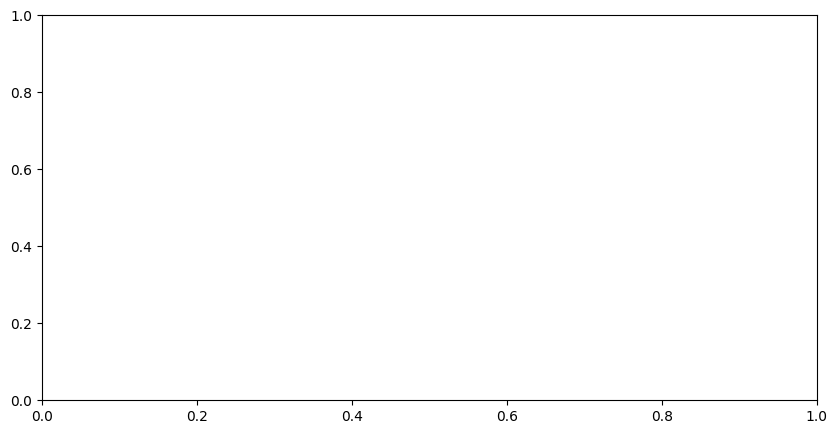

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)

In [ ]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)